# CORD19 Analysis

In [1]:
%matplotlib inline

In [ ]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [9]:
import json
import yaml
import os
import nltk
import matplotlib.pyplot as plt
import re
import pandas as pd
from nltk.corpus import stopwords 
#import plotly.graph_objects as go
import networkx as nx

# Configurations

In [4]:
# import configurations
with open('config.yaml','r') as ymlfile:
    cfg = yaml.load(ymlfile)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


## General Functions

In [103]:
def get_papers(path):
    # get list of papers .json from path
    papers = []
    for file_name in os.listdir(path):
        papers.append(file_name)
    return papers

def extract_authors(authors_list):
    '''
        Function to extract authors metadata from list of authors 
    '''
    authors = []
    for curr_author in authors_list:
        author = {}
        author['first']  = curr_author['first']
        author['middle'] = curr_author['middle']
        author['last']   = curr_author['last']
        authors.append(author)
    return authors

def extract_abstract(abstract):
    # use regex to remove 'word count: 194', get word count ?
    # use regex to remove Text word count: 5168', get text word count ?
    # remove 1,2 digit numbers that don't have text attached ? 
    stop_sentences = ['All rights reserved.','No reuse allowed without permission.','Abstract','author/funder']
    abstract_text = ''
    for section in abstract:
        abstract_text = abstract_text + ' ' + section['text']
    abstract_text = abstract_text.strip(" ")
    for s in stop_sentences:
        abstract_text = abstract_text.replace(s,"")
    return abstract_text

def extract_references(bib_entries):
    refs = []
    for r in bib_entries:
        ref = {}
        ref['id'] = bib_entries[r]['ref_id']
        ref['title'] = bib_entries[r]['title']
        ref['authors'] = bib_entries[r]['authors']
        ref['year'] = bib_entries[r]['year']
        refs.append(ref)
    return refs

def extract_paper_metadata(paper):
    paper_metadata = {}
    paper_metadata['id']       = paper['paper_id']
    paper_metadata['title']    = paper['metadata']['title']
    paper_metadata['authors']  = extract_authors(paper['authors'])
    paper_metadata['abstract'] = extract_abstract(paper['abstract'])
    paper_metadata['refs']     = extract_references(paper['bib_entries'])
    return paper_metadata

def get_paper_data(path, paper_id):
    file_path = os.path.join(path, paper_id)
    with open(file_path, 'r') as f:
        paper_info = json.load(f)
    return paper_info

## Objects

In [54]:
class Author:
    def __init__(self, firstname, middlename, lastname):
        self.firstName = firstname
        self.middleName = middlename
        self.lastName = lastname
    
    def __str__(self):
        return '{} {} {}'.format(self.firstName, self.middleName, self.lastName)

In [85]:
class Paper:
    def __init__(self, sha, title='', authors=None, date=None):
        self.id = sha
        self.title = title
        self.authors = authors
        self.date = date
        self.url = ''
    
    def __str__(self):
        s = ''
        s += 'Paper ID: {}\n'.format(self.id)
        s += 'Title: {}\n'.format(self.title)
        if self.authors:
            s += '# Authors: {}\n'.format(len(self.authors))
        else:
            s += '# Authors: 0\n'
        s += 'Date: {}\n'.format(self.date)
        s += 'URL: {}'.format(self.url)
        return s

In [7]:
path = cfg['data-path'] + biorxiv
print(path)
#paper = json.loads(path)

C:\Users\david\OneDrive\Bureau\CORD-19-research-challenge\\2020-03-13\biorxiv_medrxiv\biorxiv_medrxiv


# Metadata

In [11]:
meta = '2020-03-13/all_sources_metadata_2020-03-13.csv'
df_meta = pd.read_csv(cfg['data-path'] + meta)
df_meta.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


In [16]:
df_meta[df_meta['has_full_text']==True]

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
5,0df0d5270a9399cf4e23c0cdd877a80616a9725e,CZI,An updated estimation of the risk of transmiss...,10.1016/j.idm.2020.02.001,NaN,NaN,cc-by-nc-nd,The basic reproduction number of an infectious...,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,3.006029e+09,#729,True
6,f24242580be243d5fc3f432915d86af6854bb8b7,CZI,Real-time forecasts of the 2019-nCoV epidemic ...,10.1016/j.idm.2020.02.002,NaN,NaN,cc-by-nc-nd,The initial cluster of severe pneumonia cases ...,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,3.006029e+09,#865,True
8,e1b336d8be1a4c0ccc5a1bf41e48b3b004d3ece1,CZI,COVID-19 outbreak on the Diamond Princess crui...,10.1093/jtm/taaa030,NaN,NaN,cc-by-nc,Cruise ships carry a large number of people in...,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,3.006304e+09,#2926,True
9,e9239100c5493ea914dc23c3d7a262f4326022ac,CZI,Distinct Roles for Sialoside and Protein Recep...,10.1128/mBio.02764-19,NaN,NaN,cc-by,Coronaviruses (CoVs) are common human and anim...,2020,"Qing, Enya; Hantak, Michael; Perlman, Stanley;...",mBio,3.005811e+09,#2427,True
10,469ed0f00c09e2637351c9735c306f27acf3aace,CZI,First two months of the 2019 Coronavirus Disea...,10.1186/s41256-020-00137-4,NaN,NaN,cc-by,Similar to outbreaks of many other infectious ...,2020,"Chen, Xinguang; Yu, Bin",Global Health Research and Policy,3.006646e+09,#5595,True
11,4e550e034ccca6fa2a91e481ddba24db67bc9ae5,CZI,Effectiveness of airport screening at detectin...,10.2807/1560-7917.ES.2020.25.5.2000080,NaN,NaN,cc-by,We simulated 100 2019-nCoV infected travellers...,2020,"Quilty, Billy J; Clifford, Sam; group2, CMMID ...",Eurosurveillance,3.005152e+09,#682,True


In [21]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29500 entries, 0 to 29499
Data columns (total 14 columns):
sha                            17420 non-null object
source_x                       29500 non-null object
title                          29130 non-null object
doi                            26357 non-null object
pmcid                          27337 non-null object
pubmed_id                      16730 non-null float64
license                        17692 non-null object
abstract                       26553 non-null object
publish_time                   18248 non-null object
authors                        28554 non-null object
journal                        17791 non-null object
Microsoft Academic Paper ID    1134 non-null float64
WHO #Covidence                 1236 non-null object
has_full_text                  17420 non-null object
dtypes: float64(2), object(12)
memory usage: 3.2+ MB


In [42]:
df_meta['source_x'].unique()

array(['CZI', 'PMC', 'biorxiv', 'medrxiv'], dtype=object)

In [63]:
paper_ids = set(df_meta.iloc[:,0])
paper_ids.pop()
paper_ids

{'db459b8a4b49c8b1ad883d0824c6bffccefb525e',
 '80a789fb3ed3279911f241585e315718b54c9a91',
 '3d6462be232a3f4b4aab41386a74bb8e6a118b44',
 '7d07ea5145ff28047a49998617c8e015c5d19ece',
 '4e6709b68cb7312fda8a1c5a2b2505d21a38a1e9',
 'd90a211ef31ec56091a8c30bb8ee39e9f07ca755',
 '044e273c24dbb1ec49d20e760568a100efffab20',
 'd6303899bb27b192349eb8f8a8f5498cdc963ccd',
 'e1d8c7f82bea0b322ce13645fd051d992a2cec84',
 '8b12db91c31cd4a723270f3cbb56f7919581bb02',
 '306ae95aab18fe16957a74a8681ed32130c052f4',
 'c46022b8376c55d77bf1e504feaa1e6c5e3ed626',
 'd4f1ccfcf8b71a2828f39991e67142dd3a57fd1a',
 'cb7bbade2083d71f793469f51b908363e9f25cbd',
 'e5c06914d0daee6e881665b23adca340d0a6271a',
 '816fc25c7f0997c17db295c0a77b18b1a2375338',
 '93507716d80b9834a1ee584b038c1be54c0790a8',
 '2183478af3f9343c0f566eee8b5d95a1abea6754',
 '2238250b340cce482ba8dab2be98d10fcee965d4',
 '0d9a4673c7ff4a10e5e84667278b2fa3f8ac729f',
 'c6bf372c094f035a514975c35a7f9c094abbe493',
 'f293ae4ed7e4a778e7f9cc024d4e4cb33d69cc6e',
 '45edbd85

# biorxiv_medrxiv

In [91]:
biorxiv = '\\2020-03-13\\biorxiv_medrxiv\\biorxiv_medrxiv'
path = cfg['data-path'] + biorxiv
papers = get_papers(path)
cnt = 0
# check if paper are in metadata dataframe
for paper in papers:
    if paper[:-5] not in paper_ids:
        print(paper)
    else:
        cnt += 1
print('There are {}/{} papers present in the metadataset.'.format(cnt, len(papers)))
print('Examples:')
for paper in papers[:5]:
    print(paper)

There are 803/803 papers present in the metadataset.
Examples:
0015023cc06b5362d332b3baf348d11567ca2fbb.json
004f0f8bb66cf446678dc13cf2701feec4f36d76.json
00d16927588fb04d4be0e6b269fc02f0d3c2aa7b.json
013d9d1cba8a54d5d3718c229b812d7cf91b6c89.json
01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18.json


In [105]:
paper_info = get_paper_data(cfg['data-path'] + biorxiv, papers[10])

In [106]:
paper_info

{'paper_id': '03ea3a614b56409d3f099c9ad764864293132540',
 'metadata': {'title': 'Live-cell single RNA imaging reveals bursts of translational frameshifting',
  'authors': [{'first': 'Kenneth',
    'middle': [],
    'last': 'Lyon',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Colorado State University',
     'location': {'addrLine': 'Fort Collins',
      'postCode': '80523',
      'region': 'CO',
      'country': 'USA'}},
    'email': ''},
   {'first': 'Luis',
    'middle': ['U'],
    'last': 'Aguilera',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Colorado State University',
     'location': {'addrLine': 'Fort Collins',
      'postCode': '80523',
      'region': 'CO',
      'country': 'USA'}},
    'email': ''},
   {'first': 'Tatsuya',
    'middle': [],
    'last': 'Morisaki',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Colorado State University',
     'location': {'addrLine': 'Fort Collins'

In [101]:
extract_paper_metadata(paper_info)

TypeError: string indices must be integers

In [52]:
df_meta[df_meta['sha']==paper_info['id']]

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
28769,03ea3a614b56409d3f099c9ad764864293132540,biorxiv,Live-cell single RNA imaging reveals bursts of...,doi.org/10.1101/478040,NaN,NaN,See https://www.biorxiv.org/about-biorxiv,Ribosomal frameshifting during the translation...,2018-11-24,"Lyon, K. R.; Aguilera, L. U.; Morisaki, T.; Mu...",NaN,NaN,NaN,True


# pmc_custom_license

In [31]:
pmc = '2020-03-13\pmc_custom_license\pmc_custom_license'
path = cfg['data-path'] + pmc
pmc_papers = get_papers(path)
pmc_papers[:5]

['002f09dfc9a1323a15bf72e349d8b733ac97a2aa.json',
 '0036e8891c93ae63611bde179ada1e03e8577dea.json',
 '00573277e6be50669016f770bc28ec2da0639a8f.json',
 '00683d59d56123ae85e080d00ef1b3edd3f7405d.json',
 '0104f6ceccf92ae8567a0102f89cbb976969a774.json']

In [72]:
cnt = 0
# check if paper are in metadata dataframe
for paper in pmc_papers:
    if paper[:-5] not in paper_ids:
        print(paper)
    else:
        cnt += 1
print('There are {}/{} papers present in the metadataset.'.format(cnt, len(pmc_papers)))

There are 1426/1426 papers present in the metadataset.


In [47]:
paper_info = get_paper_data(path, pmc_papers[10])

In [48]:
paper_info

{'id': '022c31717b2ad8e7c25aab342d27c203d7e32527',
 'title': 'Virulence Potential of Fusogenic Orthoreoviruses',
 'authors': [{'first': 'Ann', 'middle': ['H'], 'last': 'Wong'},
  {'first': 'Peter', 'middle': ['K C'], 'last': 'Cheng'},
  {'first': 'Mary', 'middle': ['Y Y'], 'last': 'Lai'},
  {'first': 'Peter', 'middle': ['C K'], 'last': 'Leung'},
  {'first': 'Kitty', 'middle': ['K Y'], 'last': 'Wong'},
  {'first': 'W', 'middle': ['Y'], 'last': 'Lee'},
  {'first': 'Wilina', 'middle': ['W L'], 'last': 'Lim'},
  {'first': 'Nam', 'middle': ['Cheong'], 'last': 'St'},
  {'first': 'Kip', 'middle': [], 'last': 'Shek'},
  {'first': '', 'middle': [], 'last': 'Mei'}],
 'abstract': '',
 'refs': [{'id': 'b0',
   'title': 'The diversity of the orthoreoviruses: molecular taxonomy and phylogenetic divides',
   'authors': [{'first': 'J', 'middle': ['M'], 'last': 'Day', 'suffix': ''}],
   'year': 2009},
  {'id': 'b1',
   'title': 'Orthoreoviruses and their replication. Fields virology',
   'authors': [],

In [37]:
df_meta[df_meta['sha']=='0036e8891c93ae63611bde179ada1e03e8577dea']

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
17504,0036e8891c93ae63611bde179ada1e03e8577dea,PMC,Stable Occupancy of the Crimean-Congo Hemorrha...,http://dx.doi.org/10.1128/mBio.01065-19,PMC6650548,31337717.0,NO-CC CODE,Crimean-Congo hemorrhagic fever virus (CCHFV) ...,2019 Jul 23,"['Scholte, Florine E. M.', 'Hua, Brian L.', 'S...",mBio,NaN,NaN,True


# comm_use_subset

# noncomm_use_subset

In [11]:
# extract data from all papers
all_papers_data = []
for paper_name in papers:
    file_path = os.path.join(path,paper_name)
    with open(file_path, 'r') as f:
        paper_info = extract_paper_metadata(json.load(f))
    all_papers_data.append(paper_info)

In [12]:
for i in range(10):
    print('- {}'.format(all_papers_data[i]['title']))

- The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3
- Healthcare-resource-adjusted vulnerabilities towards the 2019-nCoV epidemic across China
- Real-time, MinION-based, amplicon sequencing for lineage typing of infectious bronchitis virus from upper respiratory samples
- Assessing spread risk of Wuhan novel coronavirus within and beyond China, January-April 2020: a travel network-based modelling study
- TWIRLS, an automated topic-wise inference method based on massive literature, suggests a possible mechanism via ACE2 for the pathological changes in the human host after coronavirus infection
- Title: Viruses are a dominant driver of protein adaptation in mammals
- The impact of regular school closure on seasonal influenza epidemics: a data-driven spatial transmission model for Belgium
- Carbon Nanocarriers Deliver siRNA to Intact Plant Cells for Efficient Gene
- Protective Population Beh

In [155]:
# get json data of current paper
file_path = os.path.join(path,papers[0])
with open(file_path, 'r') as f:
    paper = extract_paper_metadata(json.load(f))
print(paper['id'])

0015023cc06b5362d332b3baf348d11567ca2fbb


# Authors

In [13]:
def are_equal(author1, author2):
    if (author1['first'][0] == author2['first'][0]) and (author1['mid'] == author2['mid']) and (author1['last'] == author2['last']):
        return True

In [140]:
class Author:
    def __init__(self, firstname, middlename, lastname):
        self.firstName = firstname
        self.middleName = middlename
        self.lastName = lastname
        self.papers = []
    
    def __str__(self):
        return '{} {} {}'.format(self.firstName, self.middleName, self.lastName)

In [ ]:
authors = []

### Co-Authors

In [14]:
from itertools import combinations

In [15]:
co_authors_net = nx.Graph()

In [16]:
# for each paper
for i in range(len(all_papers_data)):
    # get list of authors
    co_authors = []
    for author in all_papers_data[i]['authors']:
        author_full_name = ''
        
        # only keep authors with first and last names
        if author['first'] and author['last']:
            author_full_name += author['first']
            for initial in author['middle']:
                author_full_name += ' ' + initial
            author_full_name += ' ' + author['last']
            author_full_name.strip(' ')
            co_authors.append(author_full_name)
    #print(co_authors)
    for combo in combinations(co_authors,2):
        co_authors_net.add_edge(combo[0],combo[1])
    #print('-'*60)


In [211]:
for i in combinations([1,2,3],2):
    print(i)

(1, 2)
(1, 3)
(2, 3)


C:\Users\david\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


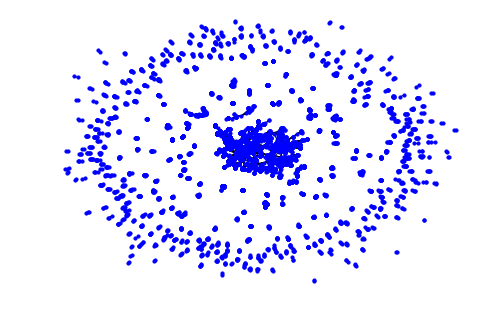

In [17]:
nx.draw(co_authors_net, node_color='blue',node_size=10)
plt.savefig("graph.png", dpi=1000)

### Reference Authors

In [177]:
for i in range(3):
    for author in all_papers_data[i]['authors']:
        print(author)
    # referenced authors
    for ref in all_papers_data[i]['refs']:
        for author in ref['authors']:
            print(author)
    print('-'*60)

{'first': 'Joseph', 'middle': ['C'], 'last': 'Ward'}
{'first': 'Lidia', 'middle': [], 'last': 'Lasecka-Dykes'}
{'first': 'Chris', 'middle': [], 'last': 'Neil'}
{'first': 'Oluwapelumi', 'middle': [], 'last': 'Adeyemi'}
{'first': 'Sarah', 'middle': [], 'last': ''}
{'first': '', 'middle': [], 'last': 'Gold'}
{'first': 'Niall', 'middle': [], 'last': 'Mclean'}
{'first': 'Caroline', 'middle': [], 'last': 'Wright'}
{'first': 'Morgan', 'middle': ['R'], 'last': 'Herod'}
{'first': 'David', 'middle': [], 'last': 'Kealy'}
{'first': 'Emma', 'middle': [], 'last': ''}
{'first': 'Warner', 'middle': [], 'last': ''}
{'first': 'Donald', 'middle': ['P'], 'last': 'King'}
{'first': 'Tobias', 'middle': ['J'], 'last': 'Tuthill'}
{'first': 'David', 'middle': ['J'], 'last': 'Rowlands'}
{'first': 'Nicola', 'middle': ['J'], 'last': ''}
{'first': 'Stonehouse', 'middle': [], 'last': 'A#'}
{'first': 'T', 'middle': [], 'last': 'Jackson', 'suffix': ''}
{'first': 'T', 'middle': ['J'], 'last': 'Tuthill', 'suffix': ''}
{

## Extracting Key Words

In [82]:
paper_json['body_text']

[{'text': 'VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structural protein-coding region is replaced by reporter genes, allow the study of genome 68 replication without the requirement for high containment (9, 10) ( figure 1A ).',
  'cite_spans': [],
  'ref_spans': [{'start': 351,
    'end': 360,
    'text': 'figure 1A',
    'ref_id': 'FIGREF50'}],
  'section': ''},
 {'text': 'The FMDV 5′ UTR is the largest known picornavirus UTR, comprising approximately 1300 71 nucleotides and containing several highly structured regions. The first 360 nucleotides at the 5′ 72 end are predicted to fold into a single large stem loop termed the S-fragment, followed by a The PKs were originally predicted in 1987 and consist of two to four tandem repeats of a ~48 86 nucleotide region containing a small stem loop and downstream interaction site (figure 1B) 87 (1

In [94]:
stop_sentences = ['All rights reserved.','No reuse allowed without permission.','Abstract','author/funder','The copyright holder for this preprint (which was not peer-reviewed) is the']
abstract_text = extract_abstract(paper_json['abstract'])
body_text = ''
for t in paper_json['body_text']:
    body_text += ' ' + t['text']
total_text = abstract_text + ' ' + body_text

for s in stop_sentences:
    total_text = total_text.replace(s,"")

print(total_text)

word count: 194 22 Text word count: 5168 23 24 25 .    27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). We investigated the structures of the PKs 34 by selective 2′ hydroxyl acetylation analysed by primer extension (SHAPE) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments. 36 SHAPE and mutation experiments confirmed the importance of the previously predicte

In [95]:
stop_words = set(stopwords.words('english'))

In [110]:
punctuation = [',','.',';',':','(',')','′','~']

In [132]:
#only keep nouns ...
other_words = set(['two','one','three','bioRxiv','furthermore','word','count','text'])
all_words = []
for word in total_text.split(" "):
    for p in punctuation:
        word = word.replace(p,"")
    word = word.strip(" ")
    try:
        int(word)
    except:
        if (not word.lower() in stop_words) and (word) and (word[:4] != 'http') and (not word.lower() in other_words):
            print(word)
            all_words.append(word)

positive
stranded
RNA
genomes
picornaviruses
comprise
single
large
open
reading
frame
flanked
untranslated
regions
UTRs
Foot-and-mouth
disease
virus
FMDV
unusually
large
UTR
kb
containing
five
structural
domains
include
internal
ribosome
entry
site
IRES
facilitates
initiation
translation
cis-acting
replication
element
cre
Less
well
characterised
structures
terminal
nucleotide
stem-loop
variable
length
poly-C-tract
approximately
100-200
nucleotides
series
four
tandemly
repeated
pseudoknots
PKs
investigated
structures
PKs
selective
hydroxyl
acetylation
analysed
primer
extension
SHAPE
analysis
determined
contribution
genome
replication
mutation
deletion
experiments
SHAPE
mutation
experiments
confirmed
importance
previously
predicted
PK
structures
function
Deletion
experiments
showed
although
PKs
essential
replication
provide
genomes
competitive
advantage
However
although
replicons
full-length
genomes
lacking
PKs
replication
competent
infectious
virus
rescued
genomes
containing
less
PK
cop

In [119]:
'also'.lower() in stop_words

False

In [107]:
try:
    print(int('5'))
except:
    print('5′ is text')

5


In [125]:
freq = nltk.FreqDist(all_words)

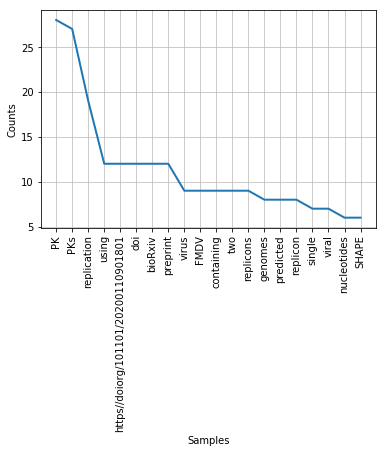

In [126]:
freq.plot(20, cumulative=False)

In [129]:
test_word = 'https//'
print(test_word[:4])

http


In [138]:
lines = 'lines is some string of words'
# function to test if something is a noun
is_noun = lambda pos: pos[:2] == 'NN'
# do the nlp stuff
tokenized = nltk.word_tokenize(total_text)
nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 

print(nouns)

['word', 'count', 'Text', 'word', 'count', 'RNA', 'genomes', 'picornaviruses', 'frame', 'regions', 'UTRs', 'disease', 'virus', 'FMDV', 'UTR', 'kb', 'domains', 'ribosome', 'entry', 'site', 'IRES', 'initiation', 'translation', 'replication', 'element', 'cre', 'Less', 'structures', 'stem-loop', 'length', 'poly-C-tract', 'nucleotides', 'series', 'tandemly', 'pseudoknots', 'PKs', 'structures', 'PKs', 'acetylation', 'primer', 'extension', 'SHAPE', 'analysis', 'contribution', 'replication', 'mutation', 'deletion', 'experiments', 'SHAPE', 'mutation', 'experiments', 'importance', 'PK', 'structures', 'function', 'Deletion', 'experiments', 'PKs', 'replication', 'genomes', 'advantage', 'replicons', 'genomes', 'PKs', 'competent', 'virus', 'genomes', 'PK', 'copy', 'report', 'presence', 'packaging', 'signals', 'PK', 'region', 'VP3', 'VP0', 'VP2', 'VP4', 'virus', 'assembly', 'P2', 'P3', 'regions', 'proteins', 'VPg', 'pro', 'region', 'reporter', 'genes', 'study', 'replication', 'requirement', 'containm

In [148]:
remove = set(['=','<','*','http','https','doi','biorxiv','preprint','word','count','text'])
words = [noun.replace('PKs','pseudoknot').replace('PK','pseudoknot') for noun in nouns if not noun.lower() in remove]

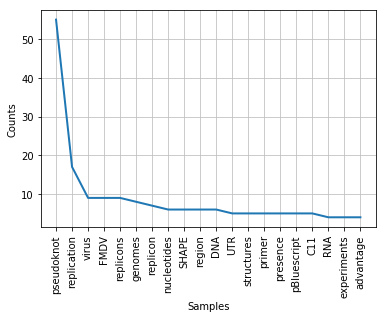

In [149]:
freq = nltk.FreqDist(words)
freq.plot(20, cumulative=False)

In [150]:
freq

FreqDist({'pseudoknot': 55, 'replication': 17, 'virus': 9, 'FMDV': 9, 'replicons': 9, 'genomes': 8, 'replicon': 7, 'nucleotides': 6, 'SHAPE': 6, 'region': 6, ...})

<bound method FreqDist.freq of FreqDist({'pseudoknot': 55, 'replication': 17, 'virus': 9, 'FMDV': 9, 'replicons': 9, 'genomes': 8, 'replicon': 7, 'nucleotides': 6, 'SHAPE': 6, 'region': 6, ...})>

# TEST

In [138]:
paper_info = get_paper_data(cfg['data-path'] + biorxiv, papers[10])

In [139]:
paper_info

{'paper_id': '03ea3a614b56409d3f099c9ad764864293132540',
 'metadata': {'title': 'Live-cell single RNA imaging reveals bursts of translational frameshifting',
  'authors': [{'first': 'Kenneth',
    'middle': [],
    'last': 'Lyon',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Colorado State University',
     'location': {'addrLine': 'Fort Collins',
      'postCode': '80523',
      'region': 'CO',
      'country': 'USA'}},
    'email': ''},
   {'first': 'Luis',
    'middle': ['U'],
    'last': 'Aguilera',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Colorado State University',
     'location': {'addrLine': 'Fort Collins',
      'postCode': '80523',
      'region': 'CO',
      'country': 'USA'}},
    'email': ''},
   {'first': 'Tatsuya',
    'middle': [],
    'last': 'Morisaki',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Colorado State University',
     'location': {'addrLine': 'Fort Collins'

In [124]:
def get_sections_from_body(body):
    sections = {}
    for section in body:
        if section['section'].isupper():
            if section['section'] not in sections:
                sections[section['section']] = ''
            else:
                sections[section['section']] += section['text']
    return sections

print(sections.keys())

dict_keys(['INTRODUCTION', 'RESULTS', 'DISCUSSION'])


In [121]:
sections

{'INTRODUCTION': 'Although frameshifting has been extensively studied in vitro and in bulk assays (Caliskan et al., 2014; Charbonneau et al., 2012; Chen et al., 2014; Lopinski et al., 2000; Mouzakis et al., 2013; Ritchie et al., 2017) , the process has never been observed at the single molecule level in living cells. This leaves many basic questions about frameshifting unresolved. In particular, it is not clear how heterogenous frameshifting is from one RNA to another, nor is it clear if single RNA continuously frameshift in a constitutive fashion or if instead they frameshift in definable bursts, as has been observed for transcription (Lionnet and Singer, 2012) and 0-frame translation (Wu et al., 2016) . Finally, the localization of frameshifting has never been investigated, so it is not clear if frameshifting occurs all throughout the cell or is instead preferentially localized to specific sub-cellular regions. In the case of HIV-1 gag-pol, for example, previous assays have shown tha

In [134]:
txt = 'INTRODUCTION'
txt[0] + txt[1:].lower()

'Introduction'

In [137]:
print('ID: {}'.format(paper_info['paper_id']))
print('\nTitle: {}'.format(paper_info['metadata']['title']))
print('\nAuthors: {}'.format(paper_info['metadata']['authors']))
print('\nAbstract: {}'.format(paper_info['abstract']))
sections = get_sections_from_body(paper_info['body_text'])
for section in sections.keys():
    print('\n{}: {}'.format(section[0] + section[1:].lower(),sections[section]))

ID: 0015023cc06b5362d332b3baf348d11567ca2fbb

Title: The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3

Authors: [{'first': 'Joseph', 'middle': ['C'], 'last': 'Ward', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Lidia', 'middle': [], 'last': 'Lasecka-Dykes', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Chris', 'middle': [], 'last': 'Neil', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Oluwapelumi', 'middle': [], 'last': 'Adeyemi', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Sarah', 'middle': [], 'last': '', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': '', 'middle': [], 'last': 'Gold', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Niall', 'middle': [], 'last': 'Mclean', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Caroline', 'middle': [], 'last': 'Wright', 'suffix': '', 'affiliation': {}, 'email': ''},

In [131]:
sections.keys()

dict_keys([])